In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from importlib import reload
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformerDropout import *
import os


In [2]:
torch.manual_seed(305)
device = 'cuda'

SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256


In [3]:
input_file_path = 'data/full_shakespeare.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 4,573,338


In [4]:
# Define a BPE model
vocab_size = 1700

tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer.decoder = decoders.ByteLevel()

# Trainer with desired vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>"])
# data should be an iterator over your text lines or documents
tokenizer.train_from_iterator([data], trainer=trainer)

# Encode and decode functions
def encode_bpe(text):
    return tokenizer.encode(text).ids

def decode_bpe(ids):
    return tokenizer.decode(ids)

# Example usage:
train_text = data[:int(len(data) * 0.9)]
val_text = data[int(len(data) * 0.9):]

train_tokens = encode_bpe(train_text)
val_tokens = encode_bpe(val_text)

train_data = torch.tensor(train_tokens)
val_data = torch.tensor(val_tokens)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")




train has 1,520,526 tokens
val has 168,070 tokens


In [47]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device, use_focal_loss=False, char_model = False):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses_by_type = {
            'ce_loss': torch.zeros(eval_iters),
        }
        if use_focal_loss:
            losses_by_type['f_loss'] = torch.zeros(eval_iters)

        for k in range(eval_iters):
            if char_model:
                X, Y = get_char_batch(split, context_window_size, device)
            else:
                X, Y = get_batch(split, context_window_size, device)
            logits, ce_loss, f_loss = model(X, Y)
            losses_by_type['ce_loss'][k] = ce_loss.item()
            if use_focal_loss:
                losses_by_type['f_loss'][k] = f_loss.item()

        out[split] = {'ce_loss': losses_by_type['ce_loss'].mean().item()}
        if use_focal_loss:
            out[split]['f_loss'] = losses_by_type['f_loss'].mean().item()

    return out

# Function for getting batches of character data
def get_char_batch(split, context_window_size, device, batch_size=32):
    """
    Generate a small batch of character-level data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: device to put tensors on
        batch_size: number of sequences in the batch
    """
    data = train_dataC if split == 'train' else val_dataC
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# Load DeepSeek as reference model with caching
def load_deepseek_reference():
    """
    Load DeepSeek reference model with caching to avoid redownloading
    """
    print("Loading DeepSeek reference model...")
    model_name = "deepseek-ai/deepseek-llm-7b-base"
    cache_dir = './deepseek_cache'

    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        cache_dir=cache_dir
    )
    model.eval()
    return model, tokenizer

def calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text):
    """
    Calculate the log probability of a text sequence under DeepSeek without length normalization
    """
    inputs = deepseek_tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get the target ids (shifted by 1 position)
        input_ids = inputs.input_ids
        target_ids = input_ids.clone()

        # Forward pass
        outputs = deepseek_model(input_ids, labels=target_ids)

        # Get the loss (negative log likelihood)
        neg_log_likelihood = outputs.loss.item()

        # Convert to log probability without normalization
        log_prob = -neg_log_likelihood

        return log_prob

def generate_text(model, prompt, encode_fn, decode_fn, max_tokens=100, temperature=1.0):
    """
    Generate text from a model using specific tokenization functions
    """
    model.eval()
    with torch.no_grad():
        # Convert prompt to tokens using model-specific tokenization
        token_ids = torch.tensor([encode_fn(prompt)], device=device)

        for _ in range(max_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]

            # Get predictions
            logits, _, _ = model(token_ids)
            logits = logits[:, -1, :] / temperature

            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to the sequence
            token_ids = torch.cat([token_ids, next_token], dim=1)

        # Decode using model-specific decoding
        generated_text = decode_fn(token_ids[0].tolist())
        return generated_text, token_ids

# Compare two Shakespeare models using DeepSeek as reference
def compare_models_with_different_tokenization(
    model_a, model_b,
    encode_a_fn, decode_a_fn,
    encode_b_fn, decode_b_fn,
    deepseek_model, deepseek_tokenizer,
    prompts, max_tokens=100, num_samples=5):
    """
    Compare two models with different tokenization methods using DeepSeek
    """
    results = {
        'model_a': {
            'texts': [],
            'log_probs': [],
            'perplexities': []
        },
        'model_b': {
            'texts': [],
            'log_probs': [],
            'perplexities': []
        }
    }

    for prompt in tqdm(prompts, desc="Evaluating prompts"):
        for _ in range(num_samples):
            # Generate samples from both models using their specific tokenization
            text_a, _ = generate_text(model_a, prompt, encode_a_fn, decode_a_fn, max_tokens)
            text_b, _ = generate_text(model_b, prompt, encode_b_fn, decode_b_fn, max_tokens)

            # Calculate log probabilities under DeepSeek
            log_prob_a = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_a)
            log_prob_b = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_b)

            # Calculate perplexity (lower is better)
            perplexity_a = np.exp(-log_prob_a)
            perplexity_b = np.exp(-log_prob_b)

            # Store results
            results['model_a']['texts'].append(text_a)
            results['model_a']['log_probs'].append(log_prob_a)
            results['model_a']['perplexities'].append(perplexity_a)

            results['model_b']['texts'].append(text_b)
            results['model_b']['log_probs'].append(log_prob_b)
            results['model_b']['perplexities'].append(perplexity_b)

    # Calculate average metrics
    results['model_a']['avg_log_prob'] = np.mean(results['model_a']['log_probs'])
    results['model_a']['avg_perplexity'] = np.mean(results['model_a']['perplexities'])
    results['model_b']['avg_log_prob'] = np.mean(results['model_b']['log_probs'])
    results['model_b']['avg_perplexity'] = np.mean(results['model_b']['perplexities'])

    return results

# Visualize comparison results
def visualize_comparison(results, model_a_name="Model A", model_b_name="Model B"):
    """
    Visualize the comparison results between two models
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot log probabilities
    ax1.bar([model_a_name, model_b_name],
            [results['model_a']['avg_log_prob'], results['model_b']['avg_log_prob']])
    ax1.set_title('Average Log Probability (higher is better)')
    ax1.set_ylabel('Log Probability')

    # Plot perplexities
    ax2.bar([model_a_name, model_b_name],
            [results['model_a']['avg_perplexity'], results['model_b']['avg_perplexity']])
    ax2.set_title('Average Perplexity (lower is better)')
    ax2.set_ylabel('Perplexity')

    plt.tight_layout()
    plt.show()

# Print sample comparisons
def print_sample_comparisons(results, num_samples=3):
    """
    Print sample text generations from both models with their metrics
    """
    print(f"{'='*20} SAMPLE COMPARISONS {'='*20}")

    for i in range(min(num_samples, len(results['model_a']['texts']))):
        print(f"\nSample {i+1}:")

        # Model A
        text_a = results['model_a']['texts'][i]
        log_prob_a = results['model_a']['log_probs'][i]
        perplexity_a = results['model_a']['perplexities'][i]

        print(f"\nModel A (Log Prob: {log_prob_a:.4f}, Perplexity: {perplexity_a:.4f}):")
        print(text_a[:500] + "..." if len(text_a) > 500 else text_a)

        # Model B
        text_b = results['model_b']['texts'][i]
        log_prob_b = results['model_b']['log_probs'][i]
        perplexity_b = results['model_b']['perplexities'][i]

        print(f"\nModel B (Log Prob: {log_prob_b:.4f}, Perplexity: {perplexity_b:.4f}):")
        print(text_b[:500] + "..." if len(text_b) > 500 else text_b)

        print(f"\n{'='*50}")

# Main function to run the comparison
def run_model_comparison_different_tokenization(model_a, model_b,
                                               encode_a_fn, decode_a_fn,
                                               encode_b_fn, decode_b_fn,
                                               prompts):
    """
    Run the full comparison between two models with different tokenization
    """
    # Load DeepSeek reference model
    deepseek_model, deepseek_tokenizer = load_deepseek_reference()
    deepseek_model = deepseek_model.to(device)

    # Compare models
    results = compare_models_with_different_tokenization(
        model_a, model_b,
        encode_a_fn, decode_a_fn,
        encode_b_fn, decode_b_fn,
        deepseek_model, deepseek_tokenizer,
        prompts, max_tokens=100, num_samples=3
    )

    # Visualize results
    visualize_comparison(results, "BPE Tokenization", "Character Tokenization")

    # Print sample comparisons
    print_sample_comparisons(results, num_samples=2)

    return results

def train_model(model, optimizer, loss_fn="ce_loss", epochs=10, is_char_model=False):
    """
    Train a model for a specified number of epochs and track losses.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        loss_fn: Which loss function to use ("ce_loss" or "focal_loss")
        epochs: Number of epochs to train for
        is_char_model: Whether this is a character model (uses different batch function)
    """
    model.train()

    # For tracking losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 100  # Number of batches per epoch

        for _ in tqdm(range(num_batches)):
            # Get batch using appropriate function
            if is_char_model:
                xb, yb = get_char_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)
            else:
                xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)

            # Forward pass
            logits, ce_loss, f_loss = model(xb, yb)

            # Use specified loss
            loss = ce_loss if loss_fn == "ce_loss" else f_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()

            # Add gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

        # Evaluate model after each epoch
        losses = estimate_loss(model, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=(loss_fn=="focal_loss"), char_model=is_char_model)
        # losses = estimate_loss(model, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device, use_focal_loss=True,)


        # Store losses for plotting
        train_loss = losses['train']['ce_loss'] if loss_fn == "ce_loss" else losses['train']['f_loss']
        val_loss = losses['val']['ce_loss'] if loss_fn == "ce_loss" else losses['val']['f_loss']

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print progress
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({loss_fn})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses



In [48]:
# Character-level tokenization
char_to_idx = {ch: i for i, ch in enumerate(sorted(set(''.join(data))))}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

def encode_char(text):
    return [char_to_idx[c] if c in char_to_idx else char_to_idx.get('', 0) for c in text]

def decode_char(ids):
    return ''.join([idx_to_char.get(id, '') for id in ids])

# Create the train and test splits for character data
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# Encode both to integers
train_dataC = torch.tensor(encode_char(train_chars))
val_dataC = torch.tensor(encode_char(val_chars))

print(f"Character train has {len(train_dataC):,} tokens")
print(f"Character val has {len(val_dataC):,} tokens")

TypeError: unhashable type: 'slice'

In [45]:
# Create models with different tokenization methods
vocab_size = 2000

# model_bpe = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE, dropout=0.1).to(device)
model_char = TransformerLM(len(char_to_idx), CONTEXT_WINDOW_SIZE).to(device)

In [ ]:
# Train models with different loss functions
# For BPE model
# train_model(model_bpe, optim.Adam(model_bpe.parameters(), lr=1e-3), loss_fn="focal_loss", epochs=20)

# For character model (with lower learning rate and gradient clipping)
train_model(model_char, optim.Adam(model_char.parameters(), lr=1e-4), loss_fn="focal_loss", epochs=20, is_char_model=True)

# # # Then load the saved parameters
# model_bpe.load_state_dict(torch.load('model_bpe.pth'))
# model_char.load_state_dict(torch.load('model_char.pth'))

# # # Set models to evaluation mode before inference
model_bpe.eval()
model_char.eval()

# Create prompts for evaluation
print("Loaded and/or trained models")

In [16]:
prompts = [
    "To be, or not to be,",
    "Friends, Romans, countrymen,",
    "Now is the winter of our discontent"
]
# Classic examples

rand_batch = get_batch("val", CONTEXT_WINDOW_SIZE, device)[0]
for x in rand_batch:
    prompts.append(decode_bpe(x.tolist()))

In [17]:
prompts

['To be, or not to be,',
 'Friends, Romans, countrymen,',
 'Now is the winter of our discontent',
 "ing together in calamity.\n\nCONSTANCE:\nTo England, if you will.\n\nKING PHILIP:\nBind up your hairs.\n\nCONSTANCE:\nYes, that I will; and wherefore will I do it?\nI tore them from their bonds and cried aloud\n'O that these hands could so redeem my son,\nAs they have given these hairs their liberty!'\nBut now I envy at their liberty,\nAnd will again commit them to their bonds,\nBecause my poor child is a prisoner.\nAnd, father cardinal, I have heard you say\nThat we shall see and know our friends in heaven:\nIf that be true, I shall see my boy again;\nFor since the birth of Cain, the first male child,\nTo him that did but yesterday suspire,\nThere was not such a gracious creature born.\nBut now will canker-sorrow eat my bud\nAnd chase the native beauty from his che",
 "'s words,\nThat speaks he knows not what?\n\nALL:\nAy, marry, will we; therefore get ye gone.\n\nWILLIAM STAFFORD:\nJac

Loading DeepSeek reference model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating prompts: 100%|██████████| 35/35 [02:43<00:00,  4.68s/it]


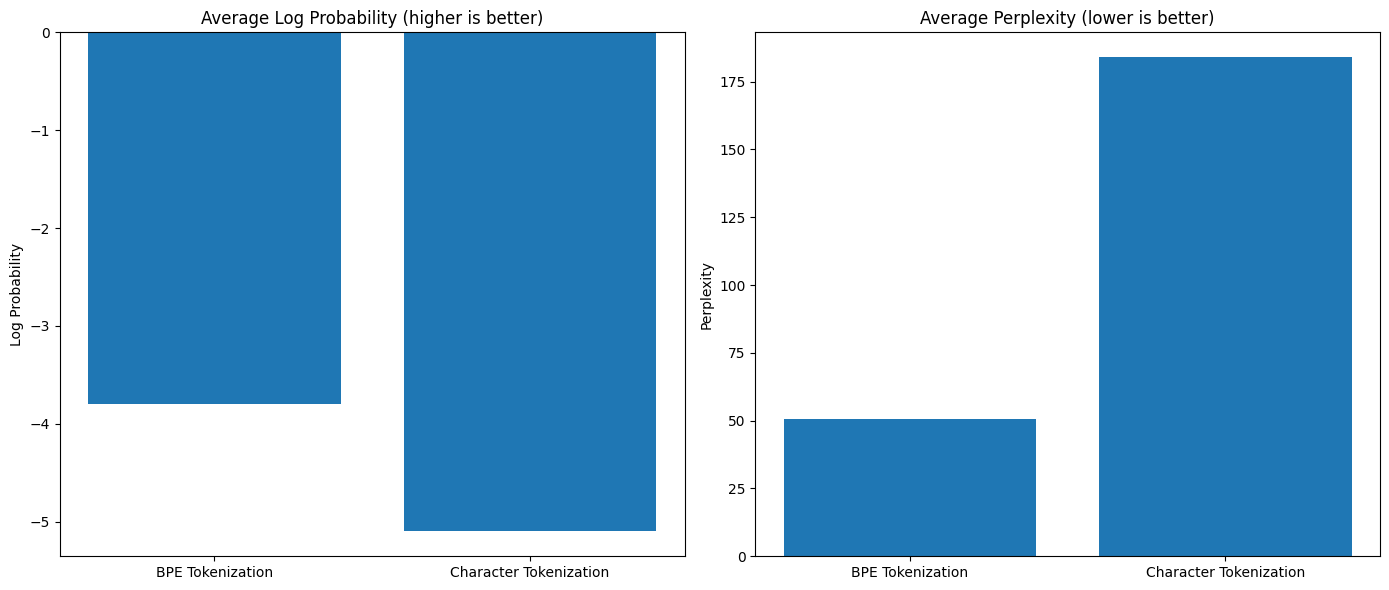

==================== SAMPLE COMPARISONS ====================

Sample 1:

Model A (Log Prob: -4.3878, Perplexity: 80.4663):
 To be, or not to be,
To any passion no further, nor the former.

KATHARINE:
By this I'll perceive it. Lord, good my liege,
Thanks, ladies:
Let us use me move, Kate, or make garment
To answer that 's me.' 'Doth I well
Have so selled that I told my guard?

GRUMIO:
About that I will to me

Model B (Log Prob: -5.4048, Perplexity: 222.4737):
To be, or not to be, what, if provaral'd
Is this may, some. God be know by speak me:
And greeling, that your fareward ne


Sample 2:

Model A (Log Prob: -2.9757, Perplexity: 19.6035):
 To be, or not to be, and you,
Cannot be abundance?

ISABELLA:
Was not my lord lost?

ANGELO:
Ay, sir:
To you, sir?

ANGELO:
I bade you, sir. And for your pardon.

ISABELLA:
For your conscience, my lord.

ANGELO:
I do beseech you now. The save your

Model B (Log Prob: -5.4338, Perplexity: 229.0247):
To be, or not to be,.

KING CLAUDIUS:
Go he not sent

In [27]:
# Run comparison
results = run_model_comparison_different_tokenization(
    model_bpe, model_char,
    encode_bpe, decode_bpe,
    encode_char, decode_char,
    prompts
)

In [15]:
# Save the final models
torch.save(model_bpe.state_dict(), 'model_bpe.pth')
torch.save(model_char.state_dict(), 'model_char.pth')

### Model comparisson

In [9]:
deepseek_model, deepseek_tokenizer = load_deepseek_reference()
deepseek_model = deepseek_model.to(device)

Loading DeepSeek reference model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
prompts = [
    "To be, or not to be,",
    "Friends, Romans, countrymen,",
    "Now is the winter of our discontent"
]
# Classic examples

rand_batch = get_batch("val", CONTEXT_WINDOW_SIZE, device, batch_size=170)[0]
for x in rand_batch:
    prompts.append(decode_bpe(x.tolist()))

In [24]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B, T, _ = x.shape
        K = self.head_size
        key = self.key(x)
        query = self.query(x)
        value = self.value(x)

        attn_scores = query@key.transpose(-2, -1)
        causal_mask = self.tril[:T, :T][None, :, :]
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
        attn_weights = torch.softmax(attn_scores / (K ** 0.5), dim=-1)
        return attn_weights@value

class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.vocab_size = vocab_size
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_ids = token_ids.clone()
        for t in range(max_new_tokens):
            logits = self(new_token_ids)
            new_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
            new_token_ids = torch.cat([new_token_ids, new_token], dim=1)
        return new_token_ids

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.lm_head = nn.Linear(embed_size*num_heads, embed_size)
        self.num_heads = num_heads

    def forward(self, x):
        # TODO, your code below
        B, T, _ = x.shape
        head_size = x.shape[-1] // self.num_heads
        head_outputs = [head(x) for head in self.heads]
        head_outputs = torch.cat(head_outputs, dim=-1)
        head_outputs = head_outputs.view(B, T, -1)
        return self.lm_head(head_outputs)

class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.multi_head_attention = MultiHeadAttention(context_window_size, num_heads, self.head_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        loss = None
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.multi_head_attention(x)
        logits = self.lm_head(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        for t in range(max_new_tokens):
            if token_ids.shape[1] > self.context_window_size:
                token_ids = token_ids[:, -self.context_window_size:]
            B, T = token_ids.shape
            logits, loss = self.forward(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, 1)
            token_ids = torch.cat([token_ids, new_token], dim=1)
        return token_ids

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size // num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

def focal_loss(logits, targets, gamma=2.0, alpha=1.0, reduction='mean'):
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    focal_factor = (1 - pt) ** gamma
    loss = alpha * focal_factor * ce_loss

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None, label_smoothing = None, focal_gamma = None):
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        logits = self.blocks(x)
        logits = self.ln_f(logits)
        logits = self.lm_head(logits)

        if targets is not None:
            if label_smoothing is None:
                ce_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
            else:
                ce_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), label_smoothing = label_smoothing)
            
            if focal_gamma is None:
                f_loss = focal_loss(logits.view(-1, logits.shape[-1]), targets.view(-1), gamma=0.3)
            else:
                f_loss = focal_loss(logits.view(-1, logits.shape[-1]), targets.view(-1), gamma=focal_gamma)

            return logits, ce_loss, f_loss
        else:
            # Return None for the loss values when targets is None
            return logits, None, None

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        self.eval()
        for _ in range(max_new_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]
            logits, _, _ = self(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_ids = torch.cat([token_ids, next_token], dim=1)
        self.train()
        return token_ids

In [25]:
results = {}

num_samples = 1
max_tokens = 100

for model_fname in [x for x in os.listdir("../") if ".pth" in x]:
    model = torch.load("../" + model_fname, weights_only=False).to(device)

    results[model_fname] = {
        "perplexities": [],
        "log_probs": [],
    }

    for prompt in tqdm(prompts, desc = f"Evaluating {model_fname}"):
        for _ in range(num_samples):
            text_a, _ = generate_text(model, prompt, encode_bpe, decode_bpe, max_tokens)
            log_prob_a = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_a)
            perplexity_a = np.exp(-log_prob_a)
            results[model_fname]["perplexities"].append(perplexity_a)
            results[model_fname]["log_probs"].append(log_prob_a)

Evaluating trained_focal_0.3.pth: 100%|██████████| 173/173 [02:12<00:00,  1.31it/s]


In [35]:
import pandas as pd
from scipy.stats import ttest_ind


In [56]:
data.keys()

dict_keys(['perplexities', 'log_probs'])

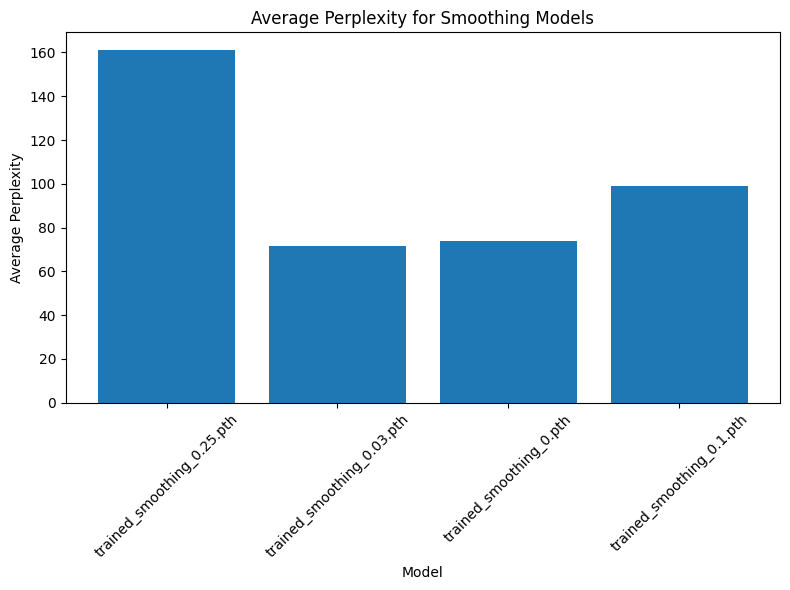

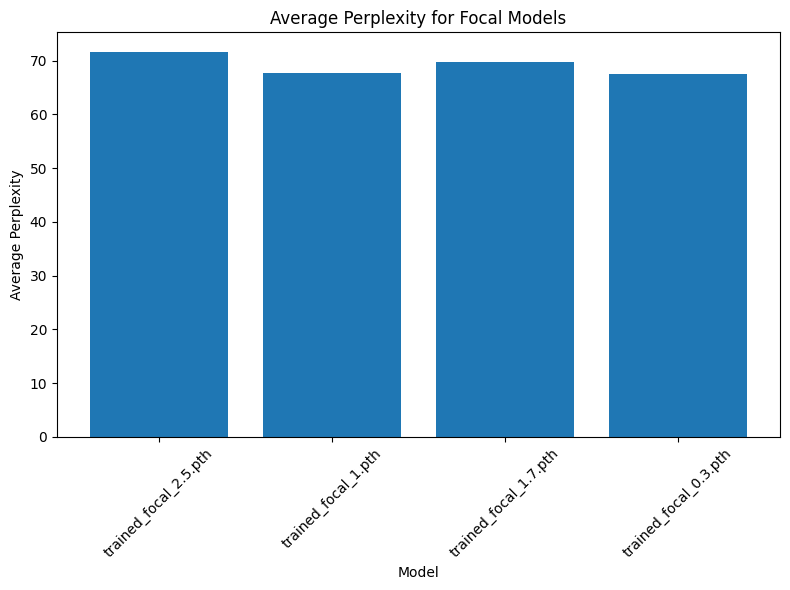

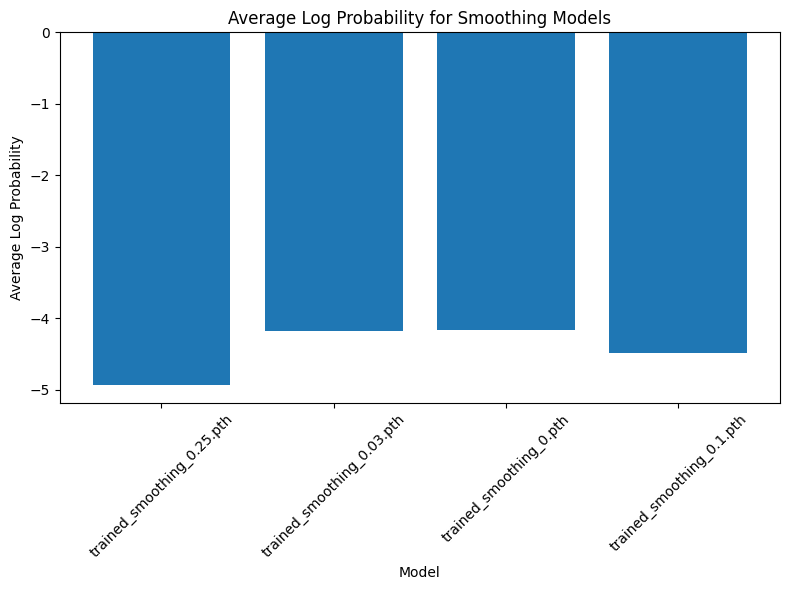

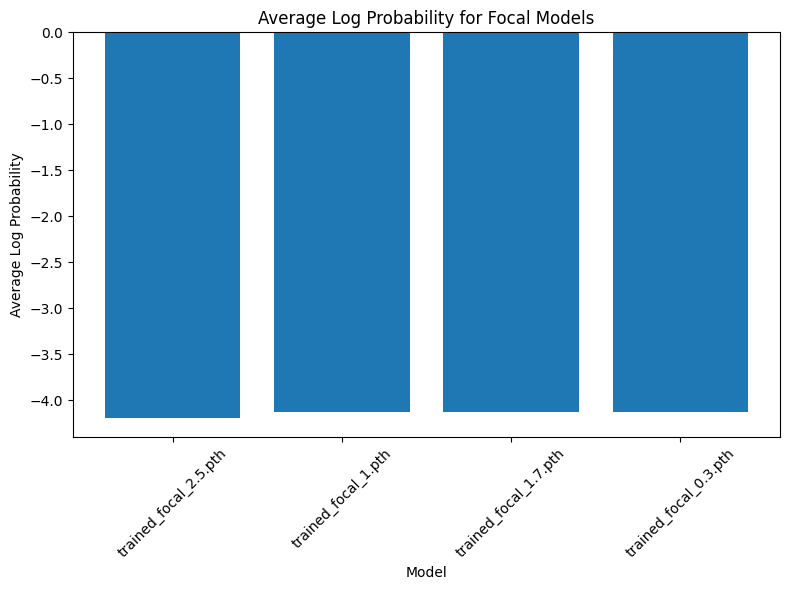

                        Model       Type  Average Perplexity  \
0  trained_smoothing_0.25.pth  smoothing          161.153704   
1       trained_focal_2.5.pth      focal           71.674328   
2  trained_smoothing_0.03.pth  smoothing           71.423885   
3         trained_focal_1.pth      focal           67.641006   
4       trained_focal_1.7.pth      focal           69.645873   
5     trained_smoothing_0.pth  smoothing           73.899704   
6   trained_smoothing_0.1.pth  smoothing           98.902364   
7       trained_focal_0.3.pth      focal           67.436825   

   Average Log Probability  
0                -4.933270  
1                -4.190296  
2                -4.175714  
3                -4.129071  
4                -4.135465  
5                -4.165423  
6                -4.491830  
7                -4.128664  


In [57]:
# Compute average perplexities and average log probabilities for each model
avg_perplexities = {}
avg_log_probs = {}
for model, data in results.items():
    avg_perplexities[model] = np.mean(data['perplexities'])
    avg_log_probs[model] = np.mean(data['log_probs'])

# Separate models by type for perplexity plots
smoothing_models = {model: avg for model, avg in avg_perplexities.items() if "smoothing" in model}
focal_models = {model: avg for model, avg in avg_perplexities.items() if "focal" in model}

# Plot bar chart for smoothing models (perplexities)
plt.figure(figsize=(8, 6))
plt.bar(list(smoothing_models.keys()), list(smoothing_models.values()))
plt.title("Average Perplexity for Smoothing Models")
plt.xlabel("Model")
plt.ylabel("Average Perplexity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot bar chart for focal models (perplexities)
plt.figure(figsize=(8, 6))
plt.bar(list(focal_models.keys()), list(focal_models.values()))
plt.title("Average Perplexity for Focal Models")
plt.xlabel("Model")
plt.ylabel("Average Perplexity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (Optional) If you also wish to plot log_probs, you could similarly separate and plot them:
smoothing_log_probs = {model: avg for model, avg in avg_log_probs.items() if "smoothing" in model}
focal_log_probs = {model: avg for model, avg in avg_log_probs.items() if "focal" in model}

plt.figure(figsize=(8, 6))
plt.bar(list(smoothing_log_probs.keys()), list(smoothing_log_probs.values()))
plt.title("Average Log Probability for Smoothing Models")
plt.xlabel("Model")
plt.ylabel("Average Log Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(list(focal_log_probs.keys()), list(focal_log_probs.values()))
plt.title("Average Log Probability for Focal Models")
plt.xlabel("Model")
plt.ylabel("Average Log Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a table summarizing the results, including both averages
data_rows = []
for model in avg_perplexities.keys():
    model_type = "smoothing" if "smoothing" in model else "focal" if "focal" in model else "other"
    data_rows.append({
        'Model': model,
        'Type': model_type,
        'Average Perplexity': avg_perplexities[model],
        'Average Log Probability': avg_log_probs[model]
    })

df_results = pd.DataFrame(data_rows)
print(df_results)

In [59]:
df_results.sort_values("Average Perplexity")

,Model,Type,Average Perplexity,Average Log Probability
7,trained_focal_0.3.pth,focal,67.436825,-4.128664
3,trained_focal_1.pth,focal,67.641006,-4.129071
4,trained_focal_1.7.pth,focal,69.645873,-4.135465
2,trained_smoothing_0.03.pth,smoothing,71.423885,-4.175714
1,trained_focal_2.5.pth,focal,71.674328,-4.190296
5,trained_smoothing_0.pth,smoothing,73.899704,-4.165423
6,trained_smoothing_0.1.pth,smoothing,98.902364,-4.491830
0,trained_smoothing_0.25.pth,smoothing,161.153704,-4.933270


In [54]:
focal_values = []
non_focal_values = []
for model, data in results.items():
    if "focal" in model:
        focal_values.extend(data['perplexities'])
    else:
        if model == "trained_smoothing_0.25.pth":
            continue
        non_focal_values.extend(data['perplexities'])

# Run a two-sample t-test on the aggregated values (assuming unequal variances)
t_stat, p_val = ttest_ind(focal_values, non_focal_values, equal_var=False)

print("Two-sample t-test comparing focal vs non-focal models (two-tailed):")
print("t-statistic =", t_stat)
print("p-value =", p_val)

Two-sample t-test comparing focal vs non-focal models (two-tailed):
t-statistic = -4.792569080826067
p-value = 1.940750470615491e-06


In [36]:
smoothing_values = []
focal_values = []
for model, data in results.items():
    if "smoothing" in model:
        smoothing_values.extend(data['perplexities'])
    elif "focal" in model:
        focal_values.extend(data['perplexities'])

# Run t-test on individual perplexities
t_stat, p_val = ttest_ind(smoothing_values, focal_values, equal_var=False)
print("T-test on individual perplexity values:")
print("t-statistic =", t_stat)
print("p-value =", p_val)

# Alternatively, compute average perplexity per model and run t-test on these averages
smoothing_avgs = [np.mean(data['perplexities']) for model, data in results.items() if "smoothing" in model]
focal_avgs = [np.mean(data['perplexities']) for model, data in results.items() if "focal" in model]

t_stat_avg, p_val_avg = ttest_ind(smoothing_avgs, focal_avgs, equal_var=False)
print("\nT-test on average perplexity per model:")
print("t-statistic =", t_stat_avg)
print("p-value =", p_val_avg)


T-test on individual perplexity values:
t-statistic = 8.462624502363214
p-value = 1.1031377234542455e-16

T-test on average perplexity per model:
t-statistic = 1.5425974229908206
p-value = 0.22020374202512483


In [37]:
best_model_name = 'trained_focal_1.pth'
best_model_perplexities = results[best_model_name]['perplexities']

# Combine perplexities from all other models
other_perplexities = []
for model, data in results.items():
    if model != best_model_name:
        other_perplexities.extend(data['perplexities'])

# Run a two-sample t-test comparing the best model with the others
t_stat, p_val = ttest_ind(best_model_perplexities, other_perplexities, equal_var=False)

print("Two-sample t-test comparing 'trained_focal_1.pth' to all other models (two-tailed):")
print("t-statistic =", t_stat)
print("p-value =", p_val)

# For a one-tailed test (testing if best model has a lower mean perplexity),
# if t_stat < 0 (meaning best model mean < others' mean), then one-tailed p-value is p_val/2.
if t_stat < 0:
    one_tailed_p = p_val / 2
else:
    one_tailed_p = 1 - (p_val / 2)

print("\nOne-tailed p-value (if lower perplexity is better):")
print("one-tailed p-value =", one_tailed_p)


Two-sample t-test comparing 'trained_focal_1.pth' to all other models (two-tailed):
t-statistic = -6.480770436373377
p-value = 1.8835909026985864e-10

One-tailed p-value (if lower perplexity is better):
one-tailed p-value = 9.417954513492932e-11


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fname = '../trained_smoothing_0.1.pth'
model = torch.load(model_fname, weights_only=False).to(device)
num_samples = 5
max_tokens = 100

results = {}

for prompt in tqdm(prompts, desc=f"Evaluating {model_fname}"):
    results[model_fname] = {
        "perplexities": [],
        "log_probs": [],
    }
    for _ in range(num_samples):
        text_a, _ = generate_text(model, prompt, encode_bpe, decode_bpe, max_tokens)
        log_prob_a = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_a)
        perplexity_a = np.exp(-log_prob_a)
        results[model_fname]["perplexities"].append(perplexity_a)
        results[model_fname]["log_probs"].append(log_prob_a)


Evaluating ../trained_smoothing_0.1.pth:   0%|          | 0/35 [00:00<?, ?it/s]


AttributeError: 'TransformerBlock' object has no attribute 'dropout'

In [12]:
device

'cuda'